# Transfer learning

<img src="images/transfer_learning.png" height="600" width="600">

- __Предобученная модель:__ проще всего – найти в интернете готовую модель для своей задачи и просто доучить со своими данными.

- __Предобученная модель с замороженными весами для извлечения признаков:__ берем классификатор [ImageNet](http://www.image-net.org/), отрезаем полносвязные слои, используем активации последних сверточных слоев в качестве признаков для другой модели (OCR, CBIR и т.д.). *Источник:* [CNN Features off-the-shelf: an Astounding Baseline for Recognition](https://arxiv.org/abs/1403.6382)

- __Дообучение модели (fine-tuning):__ тоже самое, только веса не замораживаются (или замораживаются частично), благодаря чему они будут так же донастраиваться под новую задачу методом обратного распространения ошибки. Работает это благодаря тому, что первые слои CNN выучивают низкоуровневые признаки (грани, линии) и каждый последущий слой комбинирует активации предыдущего, образуя все более и более высокоуровневые абстракции (фигуры или даже целые объекты). Низкоуровневые признаки не являются специфичными для конкретного датасета, и могут быть использованы для решения других задач. *Источник:* [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792)


## Когда и как применять перенос обучения?

- Новый датасет __маленького размера__ и __похож на оригинальный__ по содержанию. Так как он _мал_, не стоит дообучать модель из-за возможного переобучения. Так как он _похож_ на оригинальный датасет, мы предполагаем, что высокоуровневые признаки из сверточной сети будут релевантны и полезны для нового датасета. Следовательно, наилучшим решением в этом случае будет __построение нового линейного классификатора на основе высокоуровневых признаков__.

- Новый датасет __большого размера__ и __похож на оригинальный__ по содержанию. Так как теперь данных у нас больше, риск переобучиться меньше, если будем __дообучать__ сеть. Добавляем полносвязные слои, размораживаем больше слоев (может, даже размораживаем всю сеть) и учим!

- Новый датасет __маленького размера__ и __отличается от оригинального__ по содержанию. Так как данных мало, отдаем предпочтение __линейным классификаторам__. Так как содержимое отличается, возможно, не лучшим решением будет пристыковывать его именно к последним сверточнм слоям: признаки такого уровня более специфичны для оригинальной выборки. Вместо этого нужно попробовать обучить, например, SVM __на активациях более ранних слоев__ сети.

- Новый датасет __большого размера__ и __отличается от оригинального__ по содержанию. Так как данных много, можно даже попробовать __обучить классификатор с нуля__. Однако на практике все же советуют __дообучать существующие сети__: обычно это помогает сразу стартовать обучение с лучшей базовой точности и достигнуть оптимума быстрее. Да еще и, если повезет, будет точнее. И, конечно, раз данных много, можно размораживать все слои.

## Пример

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import pandas as pd

from keras.utils import np_utils
from keras.layers import Dense, Dropout, Input
from keras.models import Model
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
# from MulticoreTSNE import MulticoreTSNE as TSNE  # Он вам, скорее всего, не нужен.
                                                   # Просто не выполняйте эти ячейки и смотрите на ту картинку, 
                                                   # что есть.

SEED = 123
np.random.seed(SEED)

Using TensorFlow backend.


Загрузим набор данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

<img src="images/cifar10.png" width="500" height="500">

number of training examples = 25000
number of test examples = 10000
x_train shape: (25000, 32, 32, 3)
y_train shape: (25000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


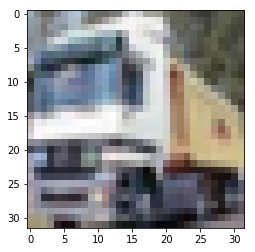

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Memory issues
M_MAX = 25_000
x_train = x_train[:M_MAX]
y_train = y_train[:M_MAX]

print("number of training examples = " + str(x_train.shape[0]))
print("number of test examples = " + str(x_test.shape[0]))
print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))
print("x_test shape: " + str(x_test.shape))
print("y_test shape: " + str(y_test.shape))

i = 1
plt.imshow(x_train[i]);

Берем предобученную InceptionV3 без последнего FC слоя и слоя пулинга

In [ ]:
model = InceptionV3(include_top=False, input_shape=(139, 139, 3))
# model.summary()

Последний слой выдает вектор признаков размером (3, 3, 2048).

В полной модели за ним следует слой пулинга 3x3 и затем FC: (3, 3, 2048) -> (2048) -> (1000)

In [4]:
model.layers[-1].output

<tf.Tensor 'mixed10/concat:0' shape=(?, 3, 3, 2048) dtype=float32>

Растягиваем картинки, чтобы размер соотвестствовал размеру входнго слоя сети: (32, 32, 3) -> (139, 139, 3).

Затем нормализуем и извлекаем признаки.

In [5]:
big_x_train = np.array([sp.misc.imresize(x_train[i], (139, 139, 3)) 
                        for i in tqdm(range(0, len(x_train)))]).astype('float32')
inception_input_train = preprocess_input(big_x_train)

features = model.predict(inception_input_train)
features = np.squeeze(features)
features = features.reshape([features.shape[0], -1]).astype('float64')

print('features shape: ', features.shape)

HBox(children=(IntProgress(value=0, max=25000), HTML(value='')))


features shape:  (25000, 18432)


Провизуализируем признаки при помощи t-SNE. 

Алгоритм позволяет получить представление точек в пространстве меньшего размера (обычно 2D).

Подробнее [тут](https://habr.com/post/267041/) и [тут](https://distill.pub/2016/misread-tsne/).

x_embedded shape:  (10000, 2)
CPU times: user 3h 57min 27s, sys: 10.1 s, total: 3h 57min 37s
Wall time: 15min 41s


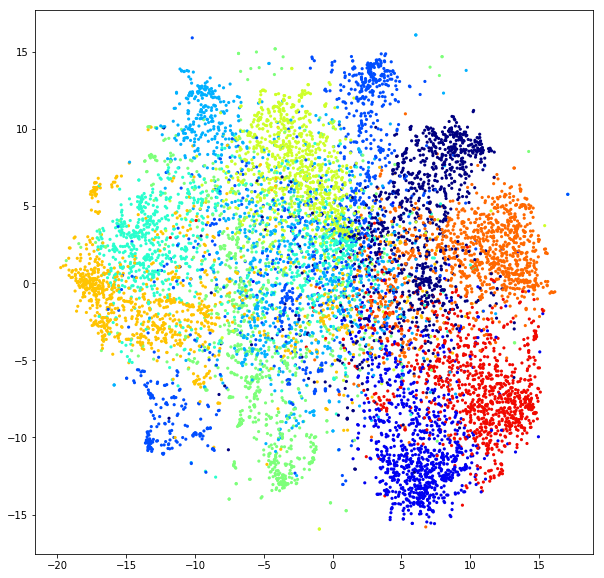

In [15]:
%%time
m = 10_000

x_embedded = TSNE(n_jobs=16, perplexity=100).fit_transform(features[:m])
print('x_embedded shape: ', x_embedded.shape)

plt.figure(figsize=(10, 10))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=plt.cm.jet(np.squeeze(y_train[:m])/10), s=10, edgecolors='none');

Проделаем те же преобразования с тестовым набором

In [16]:
big_x_test = np.array([sp.misc.imresize(x_test[i], (139, 139, 3)) 
                       for i in tqdm(range(0, len(x_test)))]).astype('float32')
inception_input_test = preprocess_input(big_x_test)

features_test = model.predict(inception_input_test)
features_test = np.squeeze(features_test)
features_test = features_test.reshape([features_test.shape[0], -1]).astype('float64')

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Преобразуем целевую переменнцю в one-hot

In [17]:
y_train = np_utils.to_categorical(y_train, 10)
y_test  = np_utils.to_categorical(y_test, 10)

Обучим простенькую модельку

In [39]:
epochs = 5
batch_size = 64

input_features = Input(features.shape[1:])
x = Dropout(0.3, seed=SEED)(input_features)
x = Dense(10, activation='softmax')(x)
model = Model(input_features, x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(features, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, verbose=2);

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 4s - loss: 1.8520 - acc: 0.7364 - val_loss: 1.3412 - val_acc: 0.8014
Epoch 2/5
 - 3s - loss: 1.2150 - acc: 0.8257 - val_loss: 1.5476 - val_acc: 0.7958
Epoch 3/5
 - 3s - loss: 1.0705 - acc: 0.8520 - val_loss: 1.8826 - val_acc: 0.7924
Epoch 4/5
 - 3s - loss: 0.9911 - acc: 0.8687 - val_loss: 1.7169 - val_acc: 0.8074
Epoch 5/5
 - 3s - loss: 0.8831 - acc: 0.8832 - val_loss: 1.6349 - val_acc: 0.8214


In [40]:
score = model.evaluate(features_test, y_test, verbose=0)
print('Test accuracy: {}'.format(100*score[1]))

Test accuracy: 81.65


# Почитать дома

* http://cs231n.github.io/transfer-learning/
* http://ruder.io/transfer-learning/